# 基本方法

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean

In [2]:
def draw_opt(opt_df):
    
    gainloss_df = pd.DataFrame()
    
    gap = 0.0001
    
    (start, end) = (mean(opt_df.loc['X']) - 0.5, mean(opt_df.loc['X']) + 0.5)
    
    
    for opt_num in opt_df.columns:
        
        opt_info = opt_df.loc[['direction', 'catagory'], opt_num].tolist()
        price = opt_df.loc['price', opt_num]
        X = opt_df.loc['X', opt_num]
        count = opt_df.loc['count', opt_num]

        if opt_info == ['buy', 'call']:  # 买入看涨期权
            
            v = [(-price * count) for i in np.arange(start, X - gap * 0.1, gap)]
            for i in np.arange(X, end - gap * 0.1, gap):
                v.append((i - X - price) * count)
                
        elif opt_info == ['buy', 'put']:  # 买入看跌期权
            
            v = []
            for i in np.arange(start, X - gap * 0.1, gap):
                v.append((X - i - price) * count)
            v += [(-price * count) for i in np.arange(X, end - gap * 0.1, gap)]
            
        elif opt_info == ['sell', 'call']:  # 卖出看涨期权
            
            v = [(price * count) for i in np.arange(start, X - gap * 0.1, gap)]
            for i in np.arange(X, end - gap * 0.1, gap):
                v.append((price - (i - X)) * count)
                
        elif opt_info == ['sell', 'put']:  # 卖出看跌期权
            
            v = []
            
            for i in np.arange(start, X - gap * 0.1, gap):
                v.append(-(X - i - price) * count)
                
            v += [(price * count) for i in np.arange(X, end - gap * 0.1, gap)]

        gainloss_df[opt_num] = v

    gainloss_df.index = np.arange(start, end - gap * 0.1, gap)
    gainloss_df['sum'] = gainloss_df['opt1'] + gainloss_df['opt2']

    plt.figure(figsize=(12, 8))
    
    # 正常显示负号
    plt.rcParams['axes.unicode_minus'] = False
    plt.plot(gainloss_df['opt1'], '--', label='opt1')
    plt.plot(gainloss_df['opt2'], '--', label='opt2')
    plt.plot(gainloss_df['sum'], c='r', label='sum')
    
    plt.axhline(0, c='gray')
    
    # 2.3 找到各条线与Y轴(图表左边界)的交点Y值并标注
    y_axis_x = start  # Y轴的X坐标就是图表的起始点
    
    # 获取各条线在Y轴位置的Y值
    opt1_y_value = gainloss_df['opt1'].iloc[0]  # 第一个点的Y值
    opt2_y_value = gainloss_df['opt2'].iloc[0]  # 第一个点的Y值
    sum_y_value = gainloss_df['sum'].iloc[0]    # 第一个点的Y值
    
    # 在Y轴上标注这些点
    plt.plot(y_axis_x, opt1_y_value, 'bo', markersize=8)
    plt.annotate(f'opt1: {opt1_y_value:.3f}', 
                xy=(y_axis_x, opt1_y_value), xytext=(y_axis_x + 0.1, opt1_y_value),
                arrowprops=dict(arrowstyle='->', color='blue'),
                fontsize=10, color='blue')
    
    plt.plot(y_axis_x, opt2_y_value, 'go', markersize=8)
    plt.annotate(f'opt2: {opt2_y_value:.3f}', 
                xy=(y_axis_x, opt2_y_value), xytext=(y_axis_x + 0.1, opt2_y_value + 0.02),
                arrowprops=dict(arrowstyle='->', color='green'),
                fontsize=10, color='green')
    
    plt.plot(y_axis_x, sum_y_value, 'ro', markersize=8)
    plt.annotate(f'sum: {sum_y_value:.3f}', 
                xy=(y_axis_x, sum_y_value), xytext=(y_axis_x + 0.1, sum_y_value - 0.02),
                arrowprops=dict(arrowstyle='->', color='red'),
                fontsize=10, color='red')
    
    # 找到sum曲线与X轴的交点（盈亏平衡点）
    def find_zero_crossings(series, x_values):
        """找到曲线与y=0的交点"""
        crossings = []
        for i in range(len(series) - 1):
            if series.iloc[i] * series.iloc[i + 1] <= 0:  # 符号改变或为0
                # 线性插值找到精确交点
                x1, y1 = x_values[i], series.iloc[i]
                x2, y2 = x_values[i + 1], series.iloc[i + 1]
                if y2 != y1:  # 避免除零
                    x_cross = x1 - y1 * (x2 - x1) / (y2 - y1)
                    crossings.append(x_cross)
        return crossings
    
    x_values = gainloss_df.index.values
    
    # 标注sum的盈亏平衡点
    sum_crossings = find_zero_crossings(gainloss_df['sum'], x_values)
    for x_cross in sum_crossings:
        plt.plot(x_cross, 0, 'ro', markersize=8)
        plt.annotate(f'平衡点: ({x_cross:.3f}, 0)', 
                    xy=(x_cross, 0), xytext=(x_cross + 0.05, 0.05),
                    arrowprops=dict(arrowstyle='->', color='red'),
                    fontsize=10, color='red')
    
    # 2.4 找到sum的最小值并标注
    min_sum = gainloss_df['sum'].min()
    min_index = gainloss_df['sum'].idxmin()
    
    # 标注最小值点
    plt.plot(min_index, min_sum, 'ro', markersize=10)
    plt.annotate(f'最小值: ({min_index:.3f}, {min_sum:.3f})', 
                xy=(min_index, min_sum), xytext=(min_index + 0.1, min_sum + 0.1),
                arrowprops=dict(arrowstyle='->', color='red', lw=2),
                fontsize=12, color='red', weight='bold')
    
    # 画虚线到Y轴
    plt.axhline(min_sum, color='red', linestyle='--', alpha=0.7)
    plt.text(start + 0.02, min_sum + 0.02, f'最小值: {min_sum:.3f}', 
             fontsize=11, color='red', weight='bold')
    
    plt.ylim(min(gainloss_df['sum']) - 0.2, max(gainloss_df['sum']) + 0.2)
    plt.xlim(start, end)
    plt.xticks(np.arange(start, end, 0.1))
    
    plt.xlabel('标的资产价格')
    plt.ylabel('损益')
    plt.title('期权组合损益分析')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()
    
    # 打印关键信息
    print("=== 关键信息汇总 ===")
    print(f"Y轴处各曲线的Y值:")
    print(f"  opt1在Y轴的值: {opt1_y_value:.4f}")
    print(f"  opt2在Y轴的值: {opt2_y_value:.4f}")
    print(f"  sum在Y轴的值: {sum_y_value:.4f}")
    
    # 计算最大收益和最大亏损
    max_sum = gainloss_df['sum'].max()
    max_index = gainloss_df['sum'].idxmax()
    
    print(f"sum曲线最小值: {min_sum:.4f}，一单最大亏损为: {abs(min_sum)*10000:.2f}")
    print(f"最小值对应的标的价格: {min_index:.4f}")
    print(f"sum曲线最大值: {max_sum:.4f}，一单最大收益为: {max_sum*10000:.2f}")
    print(f"最大值对应的标的价格: {max_index:.4f}")
    
    # 盈亏平衡点分析
    if len(sum_crossings) == 0:
        print("该组合在当前价格区间内没有盈亏平衡点")
        if sum_y_value > 0:
            print("该组合在整个价格区间内都盈利")
        else:
            print("该组合在整个价格区间内都亏损")
    elif len(sum_crossings) == 1:
        print(f"盈亏平衡点: {sum_crossings[0]:.4f}")
        if sum_y_value > 0:
            print(f"当价格小于{sum_crossings[0]:.4f}时盈利，大于时亏损")
        else:
            print(f"当价格小于{sum_crossings[0]:.4f}时亏损，大于时盈利")
    elif len(sum_crossings) >= 2:
        print(f"盈亏平衡点: {sum_crossings[0]:.4f} 和 {sum_crossings[1]:.4f}")
        print(f"当价格小于{sum_crossings[0]:.4f}或大于{sum_crossings[1]:.4f}时才会盈利")
        print(f"当价格在{sum_crossings[0]:.4f}到{sum_crossings[1]:.4f}之间时亏损")
    
    # 期权组合类型分析
    print("\n=== 期权组合分析 ===")
    opt1_info = opt_df.loc[['direction', 'catagory'], 'opt1'].tolist()
    opt2_info = opt_df.loc[['direction', 'catagory'], 'opt2'].tolist()
    
    if (opt1_info == ['sell', 'call'] and opt2_info == ['buy', 'call'] and 
        opt_df.loc['X', 'opt1'] > opt_df.loc['X', 'opt2']):
        print("这是一个熊市看涨期权价差（Bear Call Spread）组合")
        print("注意：这是一个看跌策略，当标的价格下跌时盈利")
        net_premium = opt_df.loc['price', 'opt1'] - opt_df.loc['price', 'opt2']
        strike_diff = opt_df.loc['X', 'opt1'] - opt_df.loc['X', 'opt2']
        theoretical_max_profit = net_premium  # 最大收益就是净权利金收入
        theoretical_max_loss = strike_diff - net_premium  # 最大亏损
        print(f"理论最大收益: {theoretical_max_profit:.4f} ({theoretical_max_profit*10000:.2f}元)")
        print(f"理论最大亏损: {theoretical_max_loss:.4f} ({theoretical_max_loss*10000:.2f}元)")
        print(f"净权利金收入: {net_premium:.4f}")
        print(f"执行价差: {strike_diff:.4f}")
        print(f"盈亏平衡点: {opt_df.loc['X', 'opt2'] + net_premium:.4f}")
        print("当标的价格低于盈亏平衡点时盈利，高于时亏损")
    elif (opt1_info == ['buy', 'call'] and opt2_info == ['sell', 'call'] and 
          opt_df.loc['X', 'opt1'] < opt_df.loc['X', 'opt2']):
        print("这是一个牛市看涨期权价差（Bull Call Spread）组合")
        net_premium = opt_df.loc['price', 'opt2'] - opt_df.loc['price', 'opt1']
        strike_diff = opt_df.loc['X', 'opt2'] - opt_df.loc['X', 'opt1']
        theoretical_max_profit = strike_diff - net_premium
        theoretical_max_loss = net_premium
        print(f"理论最大收益: {theoretical_max_profit:.4f} ({theoretical_max_profit*10000:.2f}元)")
        print(f"理论最大亏损: {theoretical_max_loss:.4f} ({theoretical_max_loss*10000:.2f}元)")
        print(f"净权利金支出: {net_premium:.4f}")
        print(f"执行价差: {strike_diff:.4f}")
    else:
        print("其他期权组合类型")

In [3]:
# 版本b，考虑行权
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def analyze_single_option(direction, option_type, strike_price, premium, quantity=1, 
                         price_range=None, current_price=None, expiry_month=None, 
                         intend_exercise=False):
    """
    分析单个期权的收益情况
    
    参数:
    direction: 'buy' 或 'sell' - 买入或卖出
    option_type: 'call' 或 'put' - 认购或认沽
    strike_price: 行权价
    premium: 权利金
    quantity: 期权数量（默认1）
    price_range: 价格分析区间，格式为(min_price, max_price)，默认为行权价±50%
    current_price: 当前标的价格，用于标注当前损益（可选）
    expiry_month: 到期月份，如"2024-03"（可选）
    intend_exercise: 是否打算行权（默认False）
    """
    
    # 设置价格分析区间
    if price_range is None:
        price_min = strike_price * 0.5
        price_max = strike_price * 1.5
    else:
        price_min, price_max = price_range
    
    # 生成价格序列
    gap = (price_max - price_min) / 1000  # 生成1000个点
    prices = np.arange(price_min, price_max + gap, gap)
    
    # 计算收益
    profits = []
    
    for price in prices:
        if direction == 'buy' and option_type == 'call':
            # 买入认购期权
            if price > strike_price:
                profit = (price - strike_price - premium) * quantity
            else:
                profit = -premium * quantity
                
        elif direction == 'sell' and option_type == 'call':
            # 卖出认购期权
            if price > strike_price:
                profit = -(price - strike_price - premium) * quantity
            else:
                profit = premium * quantity
                
        elif direction == 'buy' and option_type == 'put':
            # 买入认沽期权
            if price < strike_price:
                profit = (strike_price - price - premium) * quantity
            else:
                profit = -premium * quantity
                
        elif direction == 'sell' and option_type == 'put':
            # 卖出认沽期权
            if price < strike_price:
                profit = -(strike_price - price - premium) * quantity
            else:
                profit = premium * quantity
        
        profits.append(profit)
    
    # 创建DataFrame
    df = pd.DataFrame({
        'price': prices,
        'profit': profits
    })
    
    # 绘图
    plt.figure(figsize=(12, 8))
    plt.rcParams['axes.unicode_minus'] = False
    
    # 绘制收益曲线
    color_map = {
        ('buy', 'call'): 'blue',
        ('sell', 'call'): 'red',
        ('buy', 'put'): 'green',
        ('sell', 'put'): 'orange'
    }
    
    strategy_name = f"{direction.upper()} {option_type.upper()}"
    if intend_exercise:
        strategy_name += " (打算行权)"
    color = color_map.get((direction, option_type), 'black')
    
    plt.plot(df['price'], df['profit'], color=color, linewidth=2, label=strategy_name)
    
    # 添加零线
    plt.axhline(0, color='gray', linestyle='-', alpha=0.5)
    plt.axvline(strike_price, color='gray', linestyle='--', alpha=0.5, label=f'行权价: {strike_price}')
    
    # 找到盈亏平衡点
    breakeven_points = []
    for i in range(len(profits) - 1):
        if profits[i] * profits[i + 1] <= 0:  # 符号改变
            # 线性插值找到精确平衡点
            p1, profit1 = prices[i], profits[i]
            p2, profit2 = prices[i + 1], profits[i + 1]
            if profit2 != profit1:
                breakeven_price = p1 - profit1 * (p2 - p1) / (profit2 - profit1)
                breakeven_points.append(breakeven_price)
    
    # 标注盈亏平衡点
    for bp in breakeven_points:
        plt.plot(bp, 0, 'ro', markersize=10)
        plt.annotate(f'盈亏平衡点: {bp:.2f}', 
                    xy=(bp, 0), xytext=(bp + (price_max - price_min) * 0.05, max(profits) * 0.1),
                    arrowprops=dict(arrowstyle='->', color='red'),
                    fontsize=11, color='red', weight='bold')
    
    # 标注Y轴处的收益
    y_axis_profit = profits[0]
    plt.plot(price_min, y_axis_profit, 'ko', markersize=8)
    plt.annotate(f'起始收益: {y_axis_profit:.0f}', 
                xy=(price_min, y_axis_profit), 
                xytext=(price_min + (price_max - price_min) * 0.05, y_axis_profit),
                arrowprops=dict(arrowstyle='->', color='black'),
                fontsize=10, color='black')
    
    # 如果提供了当前价格，标注当前损益
    if current_price is not None and price_min <= current_price <= price_max:
        # 找到当前价格对应的收益
        current_idx = np.argmin(np.abs(prices - current_price))
        current_profit = profits[current_idx]
        
        plt.plot(current_price, current_profit, 'mo', markersize=12)
        plt.annotate(f'当前损益: {current_profit:.0f}', 
                    xy=(current_price, current_profit), 
                    xytext=(current_price + (price_max - price_min) * 0.05, current_profit + max(profits) * 0.05),
                    arrowprops=dict(arrowstyle='->', color='magenta', lw=2),
                    fontsize=12, color='magenta', weight='bold')
        
        # 添加当前价格的垂直线
        plt.axvline(current_price, color='magenta', linestyle=':', alpha=0.7, 
                   label=f'当前价格: {current_price}')
    
    # 找到最大收益和最大损失
    max_profit = max(profits)
    min_profit = min(profits)
    max_profit_price = prices[profits.index(max_profit)]
    min_profit_price = prices[profits.index(min_profit)]
    
    # 设置图表属性
    plt.xlabel('标的资产价格', fontsize=12)
    plt.ylabel('收益/损失 (元)', fontsize=12)
    
    title = f'{strategy_name} 收益分析\n行权价: {strike_price}, 权利金: {premium}, 数量: {quantity}手'
    if expiry_month:
        title += f', 到期月份: {expiry_month}'
    
    plt.title(title, fontsize=14, weight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # 调整Y轴范围
    y_range = max_profit - min_profit
    plt.ylim(min_profit - y_range * 0.1, max_profit + y_range * 0.1)
    
    plt.tight_layout()
    plt.show()
    
    # 打印分析结果
    print("=" * 60)
    print(f"期权策略分析: {strategy_name}")
    print("=" * 60)
    print(f"行权价: {strike_price}")
    print(f"权利金: {premium}")
    print(f"合约数量: {quantity}手 (每手10000个)")
    if expiry_month:
        print(f"到期月份: {expiry_month}")
    print(f"是否打算行权: {'是' if intend_exercise else '否'}")
    print(f"分析价格区间: {price_min:.2f} - {price_max:.2f}")
    print("-" * 40)
    print(f"最大收益: {max_profit:.0f}元 (标的价格: {max_profit_price:.2f})")
    print(f"最大损失: {min_profit:.0f}元 (标的价格: {min_profit_price:.2f})")
    print(f"起始位置收益: {y_axis_profit:.0f}元")
    
    if breakeven_points:
        print(f"盈亏平衡点: {[f'{bp:.2f}' for bp in breakeven_points]}")
    else:
        print("无盈亏平衡点")
    
    if current_price is not None:
        current_idx = np.argmin(np.abs(prices - current_price))
        current_profit = profits[current_idx]
        print(f"当前标的价格 {current_price} 下的收益: {current_profit:.0f}元")
    
    # 行权相关提示
    if intend_exercise:
        if direction == 'sell' and option_type == 'put':
            print("\n*** 行权提示 ***")
            print("卖沽且打算行权：如果被行权，将以行权价买入标的")
            print("如果看好标的长期表现，这种'被迫买入'可能是有利的")
        elif direction == 'sell' and option_type == 'call':
            print("\n*** 行权提示 ***")
            print("卖购且打算行权：如果被行权，将以行权价卖出标的")
            print("需要确保持有足够的标的资产用于交割")
    
    return df

## 看涨策略

## 买入看涨期权 (Long Call)
1. 策略构成：仅买入一份看涨期权（Call Option）。
2. 适用情景：*强烈看涨*。您预期股价在短期内会大幅上涨，超过“行权价 + 您支付的权利金”。
3. 目标：以小博大，利用杠杆获取股价上涨的收益。
4. 优点：风险有限（最大亏损是您支付的全部权利金），潜在收益理论上无限。
5. 缺点：权利金是纯粹的成本，如果股价不上涨或上涨幅度不够，您将损失全部或部分权利金。时间对您不利（时间价值衰减，即$\theta$损耗）


1. 买入认购期权示例:


/var/folders/jf/xkkdr4_10496xxfqshnj73200000gp/T/ipykernel_65870/862384700.py:165: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from current font.
  plt.tight_layout()
/var/folders/jf/xkkdr4_10496xxfqshnj73200000gp/T/ipykernel_65870/862384700.py:165: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  plt.tight_layout()
/var/folders/jf/xkkdr4_10496xxfqshnj73200000gp/T/ipykernel_65870/862384700.py:165: UserWarning: Glyph 36164 (\N{CJK UNIFIED IDEOGRAPH-8D44}) missing from current font.
  plt.tight_layout()
/var/folders/jf/xkkdr4_10496xxfqshnj73200000gp/T/ipykernel_65870/862384700.py:165: UserWarning: Glyph 20135 (\N{CJK UNIFIED IDEOGRAPH-4EA7}) missing from current font.
  plt.tight_layout()
/var/folders/jf/xkkdr4_10496xxfqshnj73200000gp/T/ipykernel_65870/862384700.py:165: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  plt.tight_layout()
/var/folders/jf/xkkdr4_10496xxfqshnj73200000gp/T/ipyker

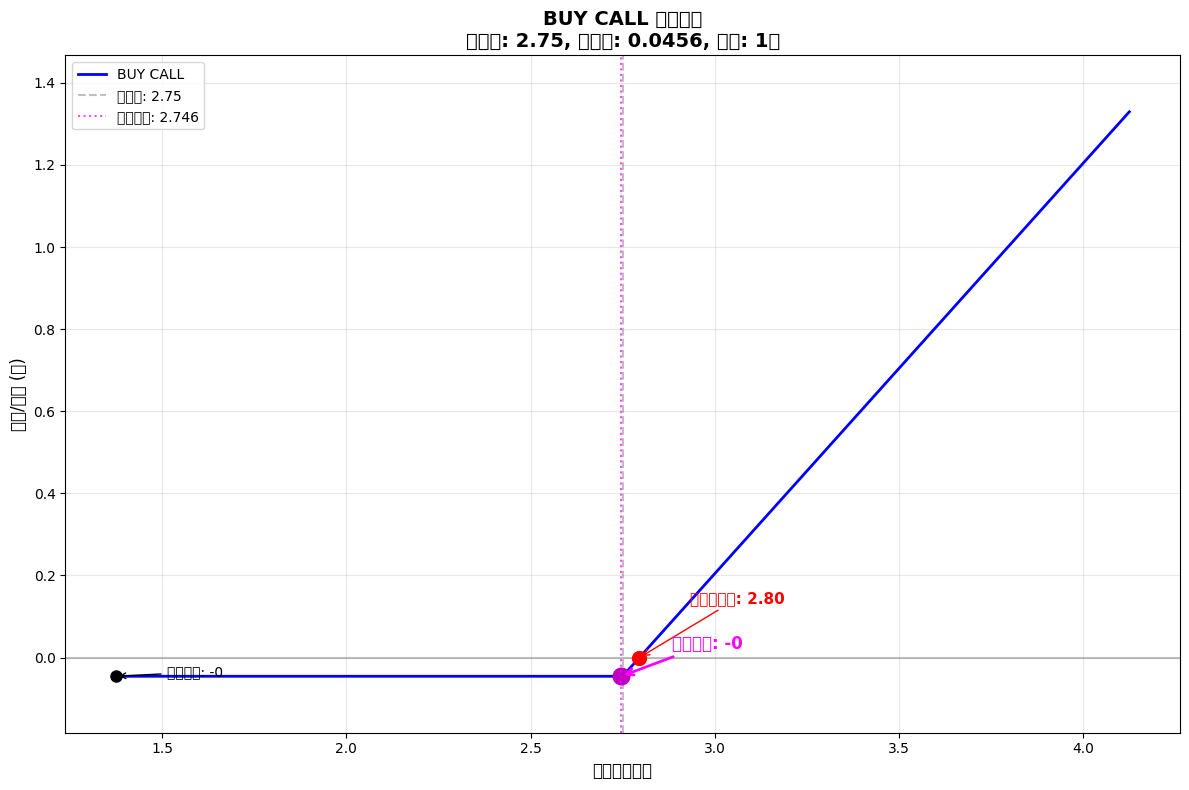

期权策略分析: BUY CALL
行权价: 2.75
权利金: 0.0456
合约数量: 1手 (每手10000个)
是否打算行权: 否
分析价格区间: 1.38 - 4.12
----------------------------------------
最大收益: 1元 (标的价格: 4.13)
最大损失: -0元 (标的价格: 1.38)
起始位置收益: -0元
盈亏平衡点: ['2.80']
当前标的价格 2.746 下的收益: -0元


In [4]:
# 示例1: 买入认购期权
print("\n1. 买入认购期权示例:")
df = analyze_single_option(
    direction='buy',
    option_type='call', 
    strike_price=2.75,
    premium=0.0456,
    quantity=1,
    current_price=2.746
)

## 牛市价差策略 (Bull Call Spread)
1. 策略构成：买入一份较低行权价的看涨期权，同时卖出一份同一到期日、但行权价较高的看涨期权。这是一个“垂直价差”策略。
2. 适用情景：温和看涨。您预期股价会上涨，但涨幅可能有限，不会超过您卖出的看涨期权的行权价。
3. 目标：降低买入期权的成本，牺牲无限的上涨空间来换取更高的获胜概率。
4. 优点：净支出（权利金成本）低于单独买入看涨期权。最大亏损也有限且已知。
5. 缺点：潜在利润有上限。如果股价出现超预期的暴涨，您的收益将被锁定。

/opt/homebrew/anaconda3/envs/common_3.8/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/envs/common_3.8/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/envs/common_3.8/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/envs/common_3.8/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26435 (\N{CJK UNIFIED IDEOGRAPH-6743}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/envs/common_3.8/lib/python3.8/site-packages/IPython/core/pylabtools.

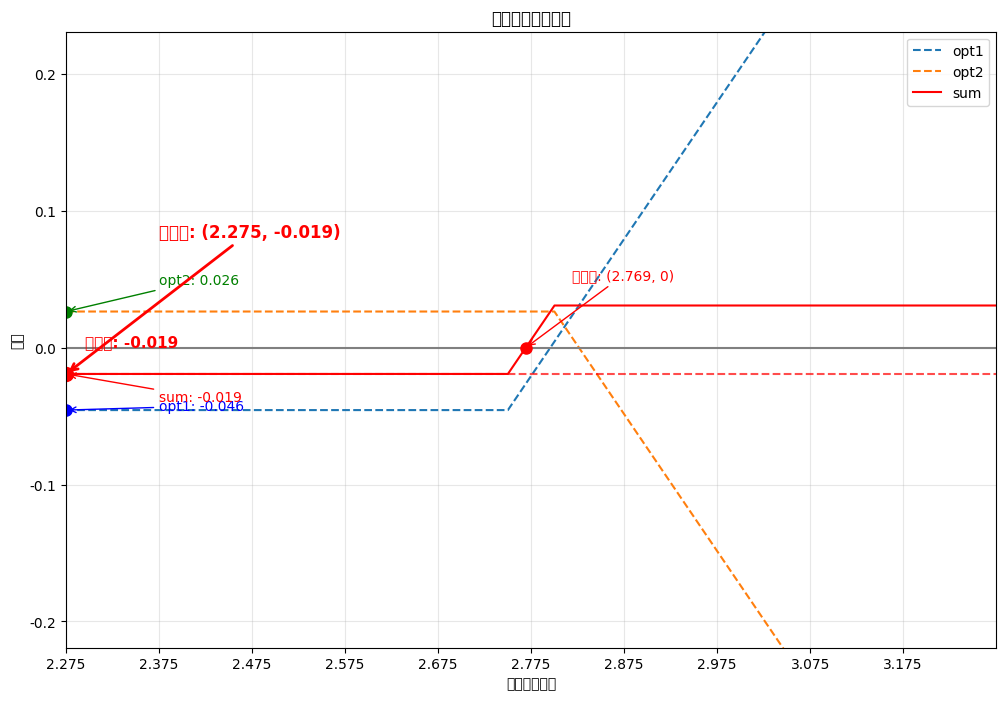

=== 关键信息汇总 ===
Y轴处各曲线的Y值:
  opt1在Y轴的值: -0.0456
  opt2在Y轴的值: 0.0264
  sum在Y轴的值: -0.0192
sum曲线最小值: -0.0192，一单最大亏损为: -192.00
最小值对应的标的价格: 2.2750


IndexError: list index out of range

In [5]:
#上证50ETF，20250615测试
opt_df = pd.DataFrame(index=['direction',  # 买卖方向
                             'catagory',   # 期权类型（call、put）
                             'price',      # 期权价格
                             'X',          # 执行价
                             'count'])     # 期权份数

opt_df['opt1'] = ['buy', 'call', 0.0456, 2.75, 1]
opt_df['opt2'] = ['sell', 'call', 0.0264, 2.8, 1]
draw_opt(opt_df)

## 卖出备兑看跌期权 (Cash-Secured Put)
1. 策略构成：卖出一份看跌期权（Put Option），并确保账户中有足够的现金，以便在期权被行权时能够按行权价买入相应数量的股票。
2. 适用情景：温和看涨或中性偏多。您不介意以行权价买入这只股票，甚至认为这是一个不错的买入点。
3. 目标：赚取卖出期权的权利金收入。如果股价下跌，则能以低于当前市价的行权价买入心仪的股票。
4. 优点：立即获得权利金收入。可以作为一种折价买入股票的策略。
5. 缺点：如果股价大幅下跌，您需要以高于市价的行权价买入股票，会产生浮亏（但亏损小于直接在当前高位买入股票）。


2. 卖出认沽期权示例（打算被行权买入标的）:


/var/folders/jf/xkkdr4_10496xxfqshnj73200000gp/T/ipykernel_65870/862384700.py:165: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from current font.
  plt.tight_layout()
/var/folders/jf/xkkdr4_10496xxfqshnj73200000gp/T/ipykernel_65870/862384700.py:165: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  plt.tight_layout()
/var/folders/jf/xkkdr4_10496xxfqshnj73200000gp/T/ipykernel_65870/862384700.py:165: UserWarning: Glyph 36164 (\N{CJK UNIFIED IDEOGRAPH-8D44}) missing from current font.
  plt.tight_layout()
/var/folders/jf/xkkdr4_10496xxfqshnj73200000gp/T/ipykernel_65870/862384700.py:165: UserWarning: Glyph 20135 (\N{CJK UNIFIED IDEOGRAPH-4EA7}) missing from current font.
  plt.tight_layout()
/var/folders/jf/xkkdr4_10496xxfqshnj73200000gp/T/ipykernel_65870/862384700.py:165: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  plt.tight_layout()
/var/folders/jf/xkkdr4_10496xxfqshnj73200000gp/T/ipyker

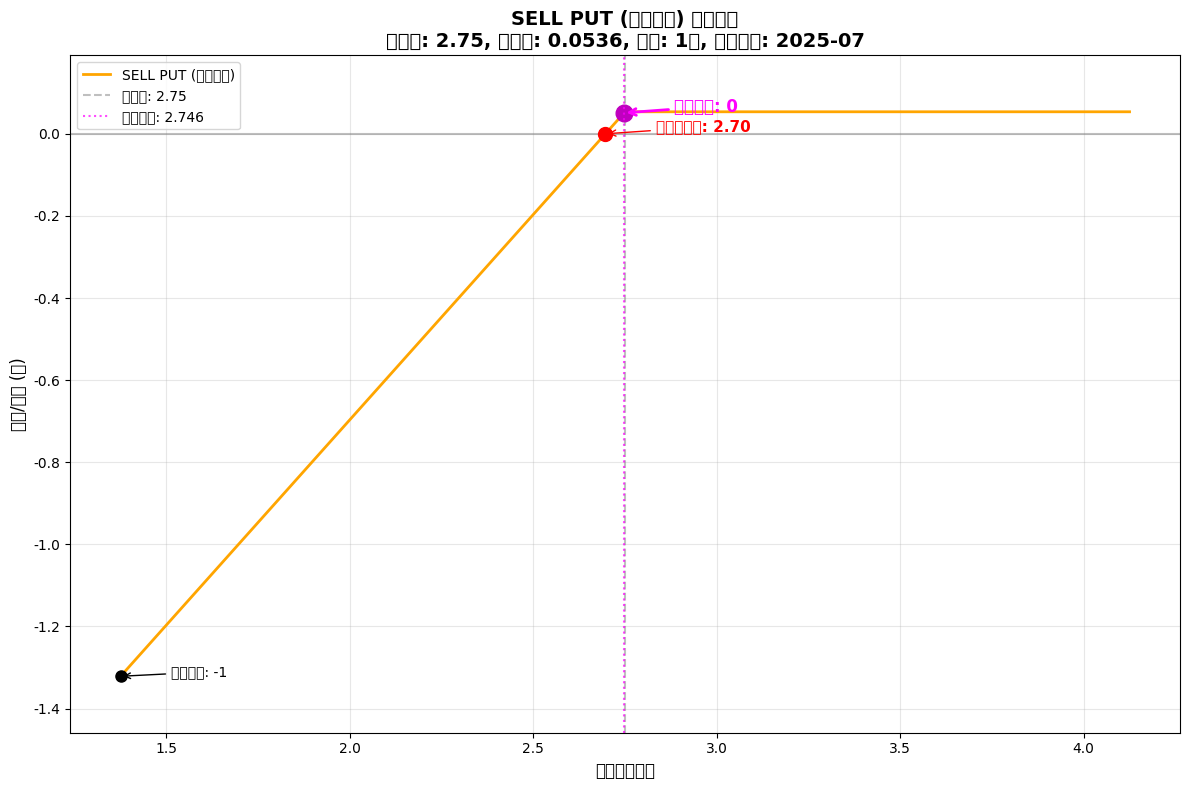

期权策略分析: SELL PUT (打算行权)
行权价: 2.75
权利金: 0.0536
合约数量: 1手 (每手10000个)
到期月份: 2025-07
是否打算行权: 是
分析价格区间: 1.38 - 4.12
----------------------------------------
最大收益: 0元 (标的价格: 2.75)
最大损失: -1元 (标的价格: 1.38)
起始位置收益: -1元
盈亏平衡点: ['2.70']
当前标的价格 2.746 下的收益: 0元

*** 行权提示 ***
卖沽且打算行权：如果被行权，将以行权价买入标的
如果看好标的长期表现，这种'被迫买入'可能是有利的


price   profit
0     1.37500 -1.32140
1     1.37775 -1.31865
2     1.38050 -1.31590
3     1.38325 -1.31315
4     1.38600 -1.31040
...       ...      ...
996   4.11400  0.05360
997   4.11675  0.05360
998   4.11950  0.05360
999   4.12225  0.05360
1000  4.12500  0.05360

[1001 rows x 2 columns]

In [6]:
# 示例3: 卖出认沽期权（打算行权）
print("\n2. 卖出认沽期权示例（打算被行权买入标的）:")
analyze_single_option(
    direction='sell',
    option_type='put',
    strike_price=2.75,
    premium=0.0536,
    quantity=1,
    current_price=2.746,
    expiry_month="2025-07",
    intend_exercise=True
)

# 看跌策略

## 买入认沽期权 (Long Put)
1. 策略构成：仅买入一份认沽期权（Put Option）。
2. 适用情景：强烈看跌。您预期股价在短期内会大幅下跌，跌破“行权价 - 您支付的权利金”。
3. 目标：从股价下跌中获利，或对冲您持有的股票多头头寸。
4. 优点：风险有限（最大亏损是支付的权利金），潜在收益巨大（股价最多跌至0）。
5. 缺点：与Long Call类似，权利金是纯成本，时间对您不利。


1. 买入认沽期权示例:


/var/folders/jf/xkkdr4_10496xxfqshnj73200000gp/T/ipykernel_65870/862384700.py:165: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from current font.
  plt.tight_layout()
/var/folders/jf/xkkdr4_10496xxfqshnj73200000gp/T/ipykernel_65870/862384700.py:165: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  plt.tight_layout()
/var/folders/jf/xkkdr4_10496xxfqshnj73200000gp/T/ipykernel_65870/862384700.py:165: UserWarning: Glyph 36164 (\N{CJK UNIFIED IDEOGRAPH-8D44}) missing from current font.
  plt.tight_layout()
/var/folders/jf/xkkdr4_10496xxfqshnj73200000gp/T/ipykernel_65870/862384700.py:165: UserWarning: Glyph 20135 (\N{CJK UNIFIED IDEOGRAPH-4EA7}) missing from current font.
  plt.tight_layout()
/var/folders/jf/xkkdr4_10496xxfqshnj73200000gp/T/ipykernel_65870/862384700.py:165: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  plt.tight_layout()
/var/folders/jf/xkkdr4_10496xxfqshnj73200000gp/T/ipyker

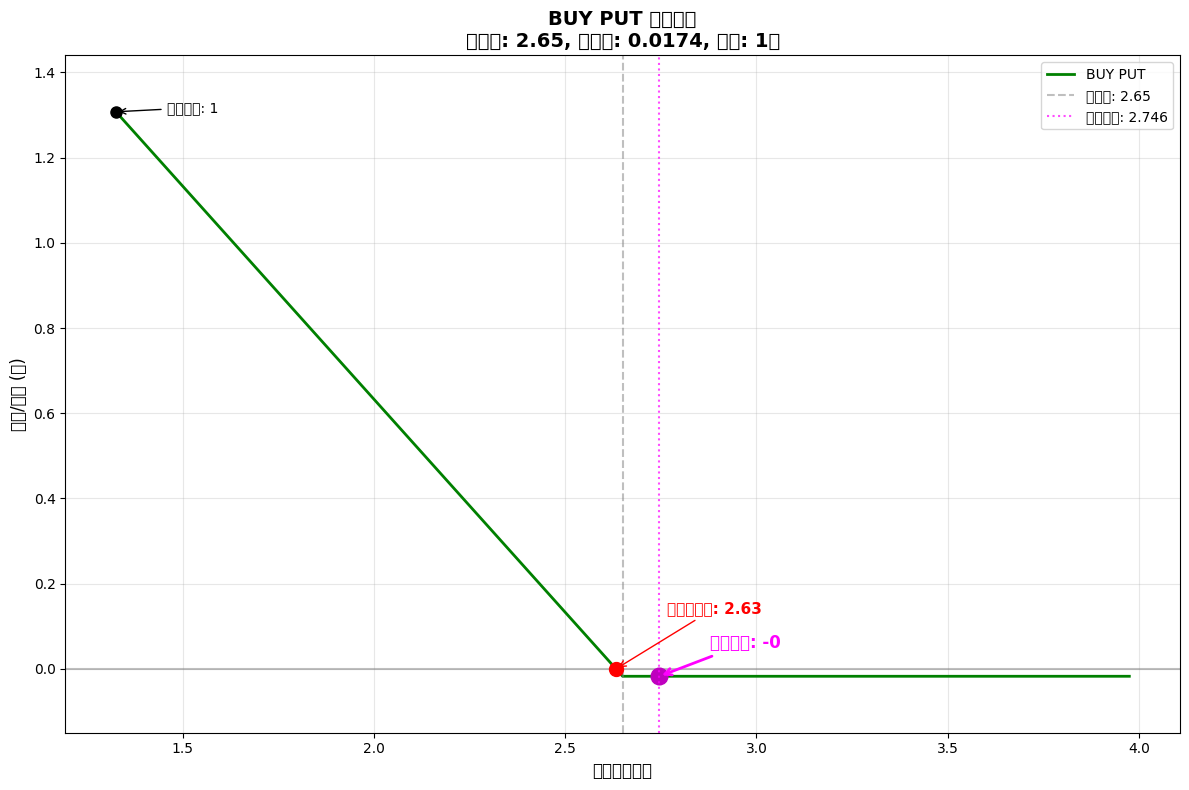

期权策略分析: BUY PUT
行权价: 2.65
权利金: 0.0174
合约数量: 1手 (每手10000个)
是否打算行权: 否
分析价格区间: 1.32 - 3.97
----------------------------------------
最大收益: 1元 (标的价格: 1.32)
最大损失: -0元 (标的价格: 2.65)
起始位置收益: 1元
盈亏平衡点: ['2.63']
当前标的价格 2.746 下的收益: -0元


In [7]:
# 示例:4 买入认沽期权
print("\n1. 买入认沽期权示例:")
df = analyze_single_option(
    direction='buy',
    option_type='put', 
    strike_price=2.65,
    premium=0.0174,
    quantity=1,
    current_price=2.746
)

## 熊市价差策略 (Bear Put Spread)
1. 策略构成：买入一份较高行权价的认沽期权，同时卖出一份同一到期日、但行权价较低的认沽期权。
2. 适用情景：温和看跌。您预期股价会下跌，但跌幅有限。
3. 目标：降低看跌策略的成本。
4. 优点：净支出低于单独买入看跌期权，最大亏损有限。
5. 缺点：潜在利润有上限。

/opt/homebrew/anaconda3/envs/common_3.8/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/envs/common_3.8/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/envs/common_3.8/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/envs/common_3.8/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26435 (\N{CJK UNIFIED IDEOGRAPH-6743}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/envs/common_3.8/lib/python3.8/site-packages/IPython/core/pylabtools.

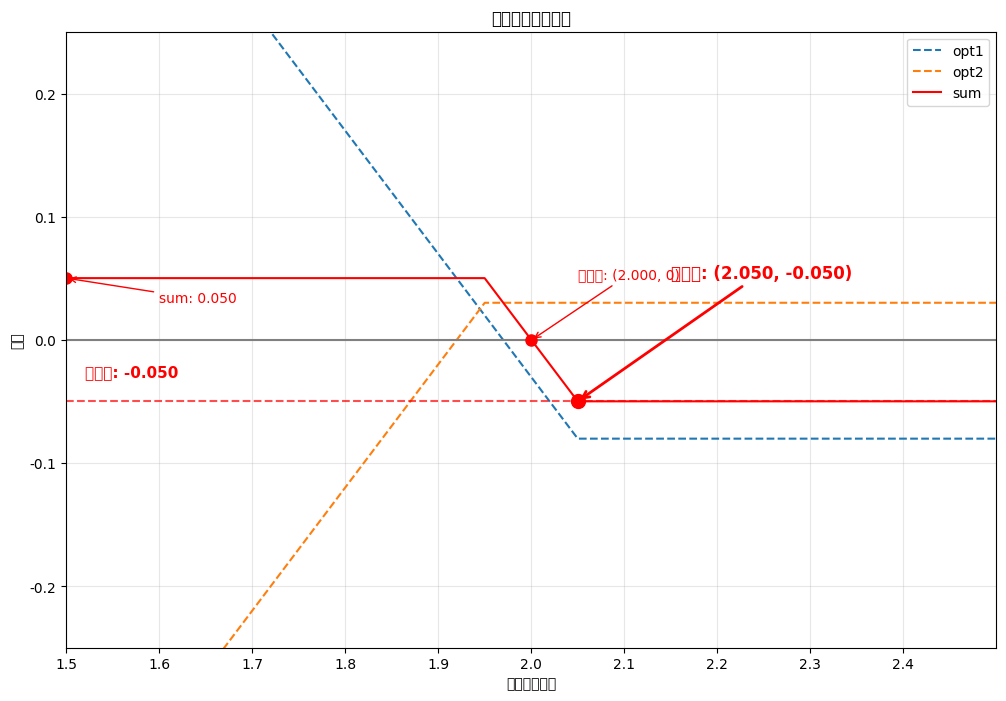

=== 关键信息汇总 ===
Y轴处各曲线的Y值:
  opt1在Y轴的值: 0.4700
  opt2在Y轴的值: -0.4197
  sum在Y轴的值: 0.0503
sum曲线最小值: -0.0497，一单最大亏损为: -497.00
最小值对应的标的价格: 2.0500


IndexError: list index out of range

In [8]:
#上证50ETF，20250615测试
opt_df = pd.DataFrame(index=['direction',  # 买卖方向
                             'catagory',   # 期权类型（call、put）
                             'price',      # 期权价格
                             'X',          # 执行价
                             'count'])     # 期权份数

opt_df['opt1'] = ['buy', 'put', 0.0800, 2.05, 1] # 高行权价
opt_df['opt2'] = ['sell', 'put', 0.0303, 1.95, 1] # 低行权价
draw_opt(opt_df)

# 中性/区间震荡策略 (Neutral/Range-Bound Strategies)
当您预期标的资产价格变化不大，将在一个特定区间内波动时，可以使用以下策略。这类策略主要通过赚取时间价值（$\theta$）来获利。

## 备兑卖出认购期权 (Covered Call)
1. 策略构成：持有至少100股标的股票，并卖出一份针对这些股票的认购期权。
2. 适用情景：中性或温和看涨。您长期看好持有的股票，但认为它在短期内不会大幅上涨，希望在持股期间创造额外收入。
3. 目标：创造现金流收入，降低持仓成本。
4. 优点：产生持续的权利金收入，如同“出租”您的股票。在股价小幅下跌、盘整或小幅上涨时均可获利。
5. 缺点：放弃了股价大幅上涨带来的潜在收益。如果股价涨破行权价，您的股票可能会被“调走”（以行权价卖出）。此策略并未对冲股价大幅下跌的风险。


1. 卖出认购期权示例:


/var/folders/jf/xkkdr4_10496xxfqshnj73200000gp/T/ipykernel_65870/862384700.py:165: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from current font.
  plt.tight_layout()
/var/folders/jf/xkkdr4_10496xxfqshnj73200000gp/T/ipykernel_65870/862384700.py:165: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  plt.tight_layout()
/var/folders/jf/xkkdr4_10496xxfqshnj73200000gp/T/ipykernel_65870/862384700.py:165: UserWarning: Glyph 36164 (\N{CJK UNIFIED IDEOGRAPH-8D44}) missing from current font.
  plt.tight_layout()
/var/folders/jf/xkkdr4_10496xxfqshnj73200000gp/T/ipykernel_65870/862384700.py:165: UserWarning: Glyph 20135 (\N{CJK UNIFIED IDEOGRAPH-4EA7}) missing from current font.
  plt.tight_layout()
/var/folders/jf/xkkdr4_10496xxfqshnj73200000gp/T/ipykernel_65870/862384700.py:165: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  plt.tight_layout()
/var/folders/jf/xkkdr4_10496xxfqshnj73200000gp/T/ipyker

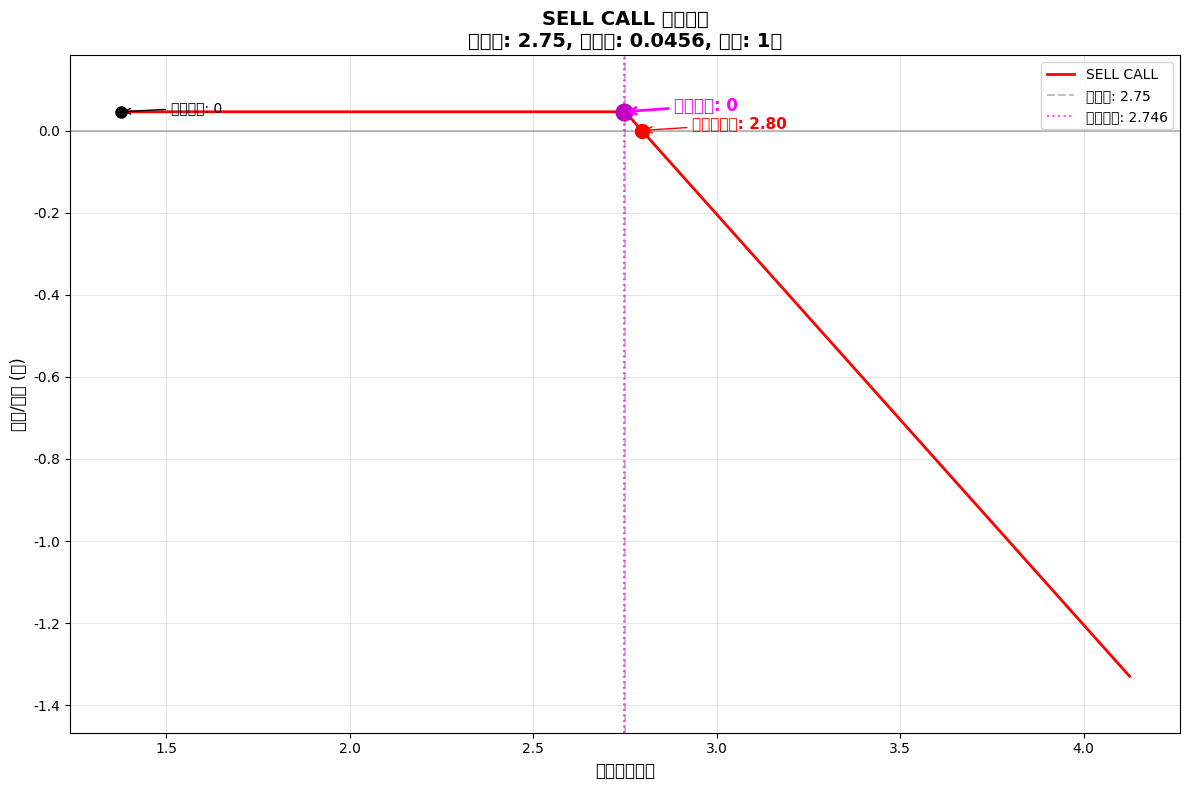

期权策略分析: SELL CALL
行权价: 2.75
权利金: 0.0456
合约数量: 1手 (每手10000个)
是否打算行权: 否
分析价格区间: 1.38 - 4.12
----------------------------------------
最大收益: 0元 (标的价格: 1.38)
最大损失: -1元 (标的价格: 4.13)
起始位置收益: 0元
盈亏平衡点: ['2.80']
当前标的价格 2.746 下的收益: 0元


In [9]:
# 示例:6 备兑卖出认购期权
print("\n1. 卖出认购期权示例:")
df = analyze_single_option(
    direction='sell',
    option_type='call', 
    strike_price=2.75,
    premium=0.0456,
    quantity=1,
    current_price=2.746
)

## 铁蝶式策略 (Iron Butterfly) / 铁鹰式策略 (Iron Condor)
1. 策略构成：
    - 铁鹰 (Iron Condor): 同时构建一个牛市价差（Bull Put Spread）和一个熊市价差（Bear Call Spread）。您卖出一个虚值的看跌期权和看涨期权，同时买入更虚值的期权作为保护。
    - 铁蝶 (Iron Butterfly): 与铁鹰类似，但卖出的看跌和看涨期权拥有相同的行权价。
2. 适用情景： 低波动性预期。您非常有把握地认为，在到期日之前，股价将在一个明确的、狭窄的区间内运行。
3. 目标： 在股价波动性小的时候，赚取时间价值衰减带来的权利金收入。
4. 优点： 高获胜概率。只要股价在设定的区间内，就能获得最大利润（收到的净权利金）。风险和回报都预先确定。
5. 缺点： 利润空间有限。如果股价突破了您设定的区间（向上或向下），就会开始亏损。

# 第四类：高波动性策略 (High Volatility Strategies)

## 买入跨式策略 (Long Straddle)
1. 策略构成： 同时买入一份平值（At-the-Money）的看涨期权和一份相同行权价、相同到期日的看跌期权。
2. 适用情景： 预期有大事件发生，股价将剧烈波动，但方向不明。
3. 目标： 无论股价是暴涨还是暴跌，只要波动的幅度足够大，就能获利。
4. 优点： 无论方向如何，都有巨大的潜在利润空间。
5. 缺点： 非常昂贵，因为您需要支付两份期权的权利金。如果股价波动不大，您将损失全部或大部分投入的权利金。这是对时间价值（$\theta$）最敏感的策略之一。

## 买入宽跨式策略 (Long Strangle)
1. 策略构成： 同时买入一份虚值（Out-of-the-Money）的看涨期权和一份虚值的看跌期权，两者到期日相同。
2. 适用情景： 与Long Straddle类似，预期剧烈波动但方向不明。
3. 目标： 与Long Straddle相同。
4. 优点： 比Long Straddle便宜，因为买入的是虚值期权。
5. 缺点： 股价需要比Long Straddle有更大的波动幅度才能开始盈利。